In [ ]:
!pip install flash_attn -q timm -q
!pip install accelerate -q
!pip install einops -q

In [ ]:
import requests

from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM

In [ ]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-large-ft", trust_remote_code=True)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large-ft", trust_remote_code=True)

In [ ]:
url = "https://thumbs.dreamstime.com/b/traffic-jam-22793720.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

In [ ]:
prompt = '<OD>'

inputs = processor(text=prompt, images=image, return_tensors="pt")

In [ ]:
%%time
generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
    )

CPU times: user 1min 18s, sys: 5.73 s, total: 1min 23s
Wall time: 1min 25s


In [ ]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [ ]:
parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))
print(parsed_answer)

{'<OD>': {'bboxes': [[58.0, 327.6089782714844, 198.0, 533.198974609375], [495.6000061035156, 372.9989929199219, 711.6000366210938, 510.2369689941406], [592.4000244140625, 281.1510009765625, 790.0, 421.5929870605469], [330.0, 294.5009765625, 502.8000183105469, 413.0489807128906], [569.2000122070312, 147.1169891357422, 704.4000244140625, 256.58697509765625], [415.6000061035156, 203.18699645996094, 554.0, 301.4429931640625], [529.2000122070312, 117.74699401855469, 646.7999877929688, 220.80899047851562], [674.7999877929688, 202.11898803710938, 798.7999877929688, 309.4530029296875], [605.2000122070312, 187.1669921875, 734.0, 287.0249938964844], [331.6000061035156, 91.58099365234375, 448.3999938964844, 191.43899536132812], [174.8000030517578, 143.91299438476562, 281.20001220703125, 222.9449920654297], [163.60000610351562, 86.77499389648438, 266.0, 167.9429931640625], [470.0, 61.676998138427734, 558.0, 146.0489959716797], [330.8000183105469, 25.898998260498047, 418.8000183105469, 88.376998901

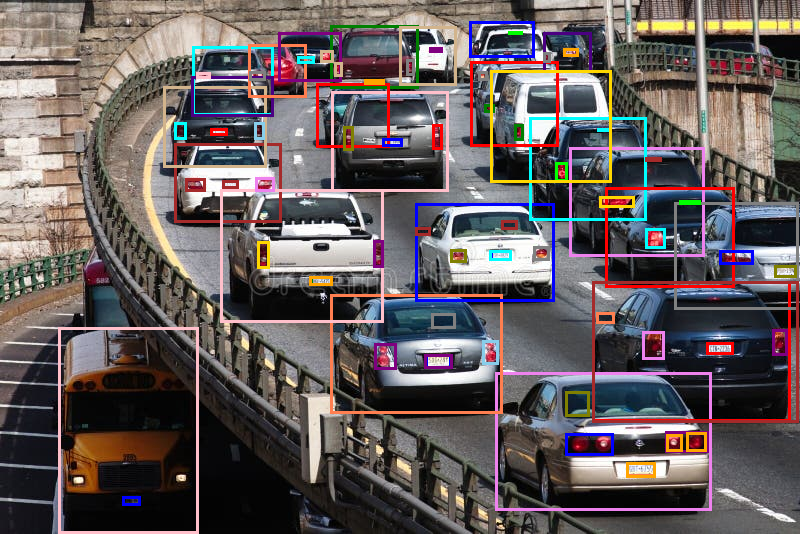

In [ ]:
import copy
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

colormap = ['blue', 'orange', 'green', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'red',
            'lime', 'indigo', 'violet', 'aqua', 'magenta', 'coral', 'gold', 'tan', 'skyblue']

def draw_od_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['bboxes'], prediction['labels']

    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        # Convert the box to a polygon format if not already in that format
        if len(box) == 4:
            new_box = [
                box[0], box[1],  # top-left
                box[2], box[1],  # top-right
                box[2], box[3],  # bottom-right
                box[0], box[3]   # bottom-left
            ]
        else:
            # If the box is already in polygon format
            new_box = box

        new_box = (np.array(new_box) * scale).tolist()
        draw.polygon(new_box, outline=color, width=3)

    display(image)


# parsed_answer = {'<OD>': {'bboxes': [...], 'labels': [...]}}
output_image = copy.deepcopy(image)
draw_od_bboxes(output_image, parsed_answer['<OD>'])
